### Imports

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

### Data inspection  

In [3]:
# Load the full .dat file (timestamp + power)
df = pd.read_csv("channel_1.dat", sep=" ", names=["timestamp", "power"])

# Convert timestamp to datetime
df["time"] = pd.to_datetime(df["timestamp"], unit="s")

# Reorder columns for clarity
df = df[["time", "power"]]

# Save the full dataset as CSV
df.to_csv("channel_1.csv", index=False)

# Display the first few rows of the dataframe
print(df.head())



                 time  power
0 2012-11-09 22:28:15    599
1 2012-11-09 22:28:21    582
2 2012-11-09 22:28:27    600
3 2012-11-09 22:28:33    586
4 2012-11-09 22:28:40    596


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6266402 entries, 0 to 6266401
Data columns (total 2 columns):
 #   Column  Dtype         
---  ------  -----         
 0   time    datetime64[ns]
 1   power   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 95.6 MB


In [5]:
df.describe()

,time,power
count,6266402,6.266402e+06
mean,2013-08-06 05:52:08.739235072,3.525512e+02
min,2012-11-09 22:28:15,4.600000e+01
25%,2013-04-19 03:00:37.500000,1.810000e+02
50%,2013-08-09 12:22:35,2.370000e+02
75%,2013-11-30 14:38:55.500000,3.710000e+02
max,2014-03-24 06:15:20,8.054000e+03
std,NaN,4.063456e+02


In [6]:
# Resample to daily means
df_daily = df.set_index("time").resample("D").mean()

# Show missing days after resampling
missing_days = df_daily[df_daily["power"].isna()]
print(missing_days)

            power
time             
2012-11-24    NaN
2012-11-25    NaN
2012-12-04    NaN
2012-12-05    NaN
2012-12-06    NaN
2012-12-07    NaN
2012-12-08    NaN
2012-12-09    NaN
2012-12-10    NaN
2012-12-11    NaN
2012-12-18    NaN
2012-12-19    NaN
2012-12-20    NaN
2012-12-21    NaN
2013-01-11    NaN
2013-01-12    NaN
2013-01-13    NaN
2013-01-14    NaN
2013-01-15    NaN
2013-01-16    NaN
2013-01-29    NaN
2013-01-30    NaN
2013-01-31    NaN
2013-02-01    NaN
2013-02-02    NaN
2013-02-03    NaN
2013-02-04    NaN
2013-02-05    NaN
2013-02-06    NaN
2013-02-07    NaN


In [7]:
# First few rows
print(df.head())

# Last few rows
print(df.tail())


                 time  power
0 2012-11-09 22:28:15    599
1 2012-11-09 22:28:21    582
2 2012-11-09 22:28:27    600
3 2012-11-09 22:28:33    586
4 2012-11-09 22:28:40    596
                       time  power
6266397 2014-03-24 06:14:56    200
6266398 2014-03-24 06:15:02    200
6266399 2014-03-24 06:15:08    200
6266400 2014-03-24 06:15:14    203
6266401 2014-03-24 06:15:20    202


### Visualisation 

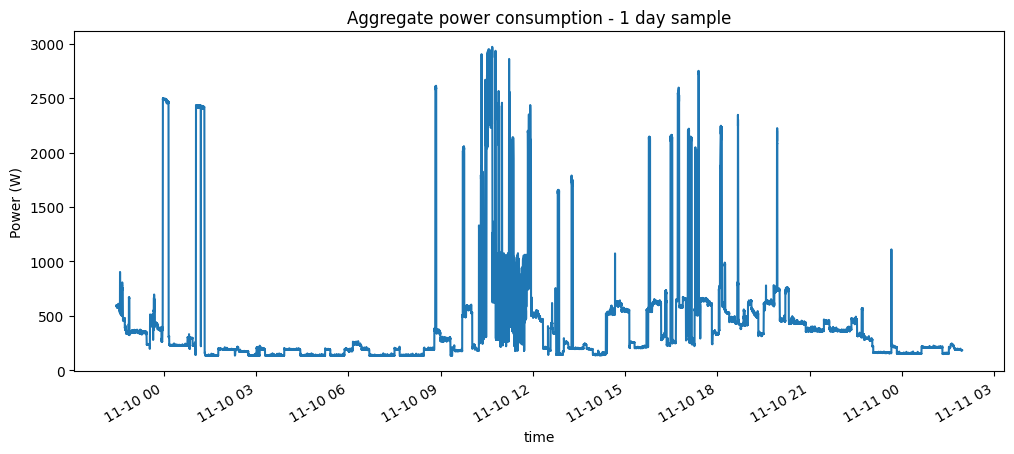

In [8]:
# Select a 1-day sample for visualization
df_day = df.set_index("time").iloc[:24*60*10]   
df_day["power"].plot(figsize=(12,5))
plt.title("Aggregate power consumption - 1 day sample")
plt.ylabel("Power (W)")
plt.show()


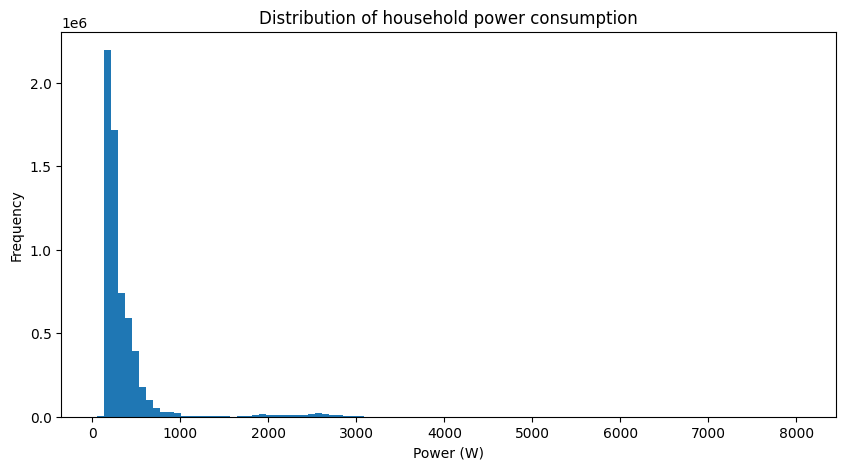

In [9]:
# Plot histogram of power consumption
df["power"].plot(kind="hist", bins=100, figsize=(10,5))
plt.title("Distribution of household power consumption")
plt.xlabel("Power (W)")
plt.show()


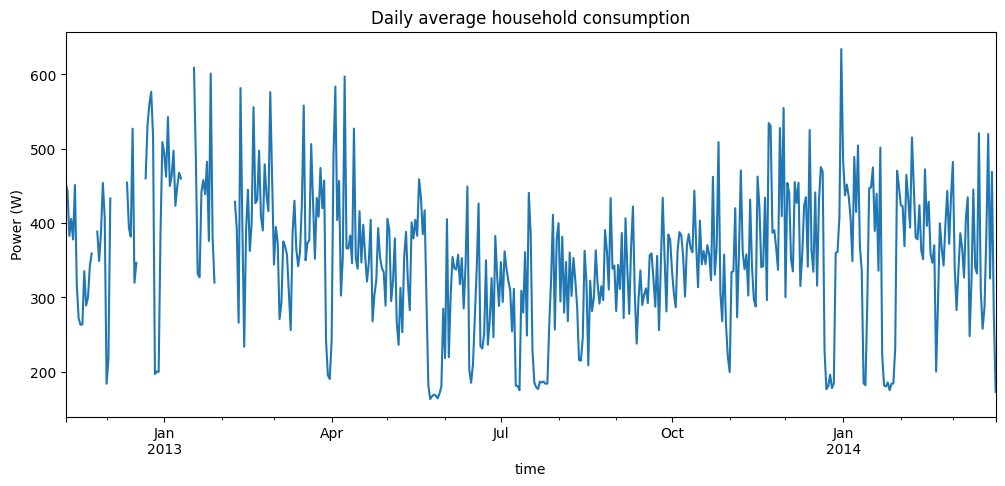

In [10]:
# Daily average over the entire dataset
df_daily = df.set_index("time").resample("D").mean()

# Plot the full span
df_daily.plot(figsize=(12,5), legend=False)
plt.title("Daily average household consumption")
plt.ylabel("Power (W)")
plt.show()


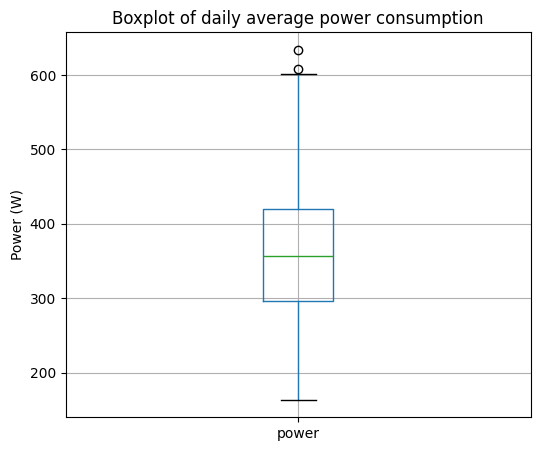

In [11]:
# Boxplot of daily average power consumption
df_daily.boxplot(column="power", figsize=(6,5))
plt.title("Boxplot of daily average power consumption")
plt.ylabel("Power (W)")
plt.show()


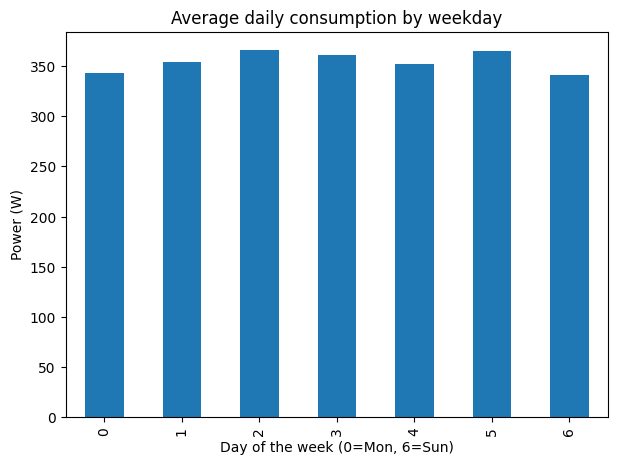

In [12]:
# Average daily consumption by weekday
df_daily["weekday"] = df_daily.index.weekday
df_daily.groupby("weekday")["power"].mean().plot(kind="bar", figsize=(7,5))
plt.title("Average daily consumption by weekday")
plt.ylabel("Power (W)")
plt.xlabel("Day of the week (0=Mon, 6=Sun)")
plt.show()


### Preprocessing

In [13]:
# Load the cleaned CSV for further analysis
df = pd.read_csv("channel_1.csv", parse_dates=["time"])
df = df.sort_values("time").set_index("time")

df.head()


,power
time,
2012-11-09 22:28:15,599
2012-11-09 22:28:21,582
2012-11-09 22:28:27,600
2012-11-09 22:28:33,586
2012-11-09 22:28:40,596


In [14]:
# Convert 6-second readings to hourly averages
df_hourly = df.resample("H").mean()
df_hourly.head()


C:\Users\vithu\AppData\Local\Temp\ipykernel_23496\1968579545.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hourly = df.resample("H").mean()


,power
time,
2012-11-09 22:00:00,474.804428
2012-11-09 23:00:00,442.738050
2012-11-10 00:00:00,608.406844
2012-11-10 01:00:00,826.403377
2012-11-10 02:00:00,173.122137


In [15]:
# Add date and hour helper columns
tmp = df_hourly.copy()
tmp["date"] = tmp.index.date
tmp["hour"] = tmp.index.hour

# Pivot to one row per day, 24 columns (hour 0..23)
daily_profiles = tmp.pivot_table(index="date", columns="hour", values="power", aggfunc="mean")

# Ensure all hour columns (0..23) exist
daily_profiles = daily_profiles.reindex(columns=range(24))

# DROP INCOMPLETE DAYS 
before = daily_profiles.shape[0]
daily_profiles = daily_profiles.dropna()
after = daily_profiles.shape[0]
print(f"Dropped {before - after} incomplete days. Remaining complete days: {after}")

# Rename columns for clarity
daily_profiles.columns = [f"hour_{h}" for h in range(24)]

daily_profiles.head()


Dropped 31 incomplete days. Remaining complete days: 440


,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
date,,,,,,,,,,,,,,,,,,,,,
2012-11-10,608.406844,826.403377,173.122137,154.565714,163.299603,153.617871,187.295113,146.968992,260.916828,392.410781,...,399.506641,432.701689,677.835590,709.770270,625.929273,583.207294,475.489603,382.159615,365.291115,178.406780
2012-11-11,176.428839,193.463511,180.896750,225.607143,169.881226,223.175676,184.098859,390.975000,372.091429,234.073034,...,1006.789091,403.832381,184.627413,433.360000,579.778203,1167.113027,834.287356,462.610586,314.762082,177.636711
2012-11-12,165.011111,228.143389,168.808271,191.515444,198.084404,310.651252,420.702857,208.892514,559.804391,962.046555,...,276.199226,270.818352,674.739837,673.634615,619.042484,265.888112,357.323529,579.445026,494.561279,188.834783
2012-11-13,250.744015,182.117318,190.641208,176.683012,197.067138,188.019400,195.385841,361.473779,446.112523,192.962832,...,179.052632,217.333333,1385.333333,866.330784,546.365108,523.639576,442.213382,568.327338,318.219684,207.423214
2012-11-14,199.103327,208.220690,181.644128,188.324561,175.686594,235.830986,267.168421,401.835106,403.633157,242.845878,...,643.752294,314.659091,313.687389,825.776801,687.139130,1367.397749,700.546961,453.603908,785.115248,833.926702


In [16]:
# Remove outliers based on total daily consumption
daily_totals = daily_profiles.sum(axis=1)
q_low, q_high = daily_totals.quantile([0.01, 0.99])

daily_profiles = daily_profiles[(daily_totals > q_low) & (daily_totals < q_high)]

print("Days remaining after removing outliers:", daily_profiles.shape[0])


Days remaining after removing outliers: 430


In [17]:
# Standardize features (mean=0, std=1)
X = daily_profiles.values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Feature matrix shape:", X_scaled.shape)  # (n_days, 24)


Feature matrix shape: (430, 24)


In [18]:
# Save the daily profiles to CSV
daily_profiles.to_csv("daily_profiles_24h.csv")
print("Saved: daily_profiles_24h.csv")


Saved: daily_profiles_24h.csv


### K-Means clustering 

In [19]:
# Number of clusters
k = 3  

km = KMeans(n_clusters=k, n_init=20, random_state=42)
labels = km.fit_predict(X_scaled)

# Silhouette score for cluster quality
sil = silhouette_score(X_scaled, labels)
print("Silhouette score:", sil)


Silhouette score: 0.10121811133988447


In [20]:
# Add cluster labels to the original daily profiles
profiles_labeled = daily_profiles.copy()
profiles_labeled["cluster"] = labels

print(profiles_labeled.head())
print("Cluster sizes:")
print(profiles_labeled["cluster"].value_counts())


                hour_0      hour_1      hour_2      hour_3      hour_4  \
date                                                                     
2012-11-10  608.406844  826.403377  173.122137  154.565714  163.299603   
2012-11-11  176.428839  193.463511  180.896750  225.607143  169.881226   
2012-11-12  165.011111  228.143389  168.808271  191.515444  198.084404   
2012-11-13  250.744015  182.117318  190.641208  176.683012  197.067138   
2012-11-14  199.103327  208.220690  181.644128  188.324561  175.686594   

                hour_5      hour_6      hour_7      hour_8      hour_9  ...  \
date                                                                    ...   
2012-11-10  153.617871  187.295113  146.968992  260.916828  392.410781  ...   
2012-11-11  223.175676  184.098859  390.975000  372.091429  234.073034  ...   
2012-11-12  310.651252  420.702857  208.892514  559.804391  962.046555  ...   
2012-11-13  188.019400  195.385841  361.473779  446.112523  192.962832  ...   
2012-11

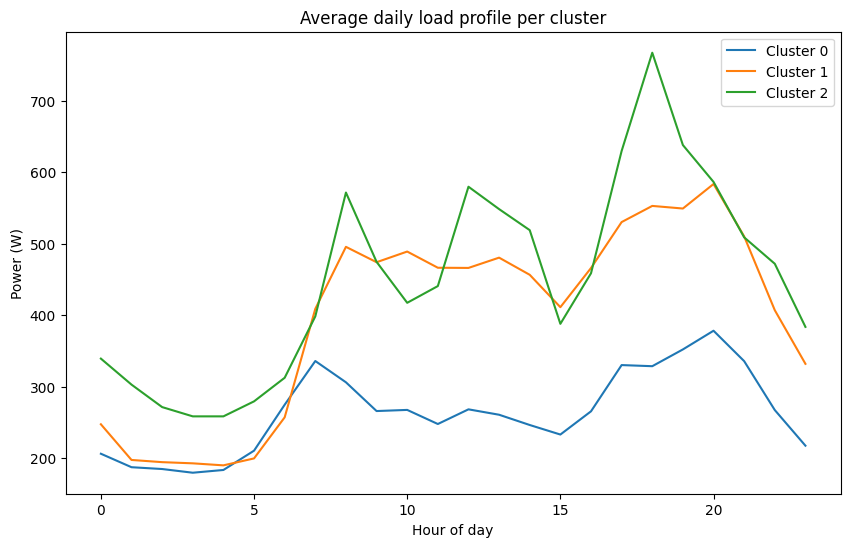

In [21]:
# Plot average profile per cluster
cluster_means = profiles_labeled.groupby("cluster").mean()

plt.figure(figsize=(10,6))
for c in cluster_means.index:
    plt.plot(range(24),
             cluster_means.loc[c],
             label=f"Cluster {c}")
plt.title("Average daily load profile per cluster")
plt.xlabel("Hour of day")
plt.ylabel("Power (W)")
plt.legend()
plt.show()


### K-Means clustering with PCA

In [ ]:
# PCA for dimensionality reduction and variance explanation
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

print("Explained variance ratio (PC1, PC2):", pca.explained_variance_ratio_)
print("Cumulative variance (2 PCs):", pca.explained_variance_ratio_.sum())


Explained variance ratio (PC1, PC2): [0.19640193 0.09030597]
Cumulative variance (2 PCs): 0.28670790261790524


In [23]:
# KMeans clustering in PCA-reduced space
k = 3
km_pca = KMeans(n_clusters=k, n_init=20, random_state=42)
labels_pca = km_pca.fit_predict(X_pca)

sil_pca = silhouette_score(X_pca, labels_pca)
print("Silhouette (PCA space):", sil_pca)


Silhouette (PCA space): 0.38340831262898434


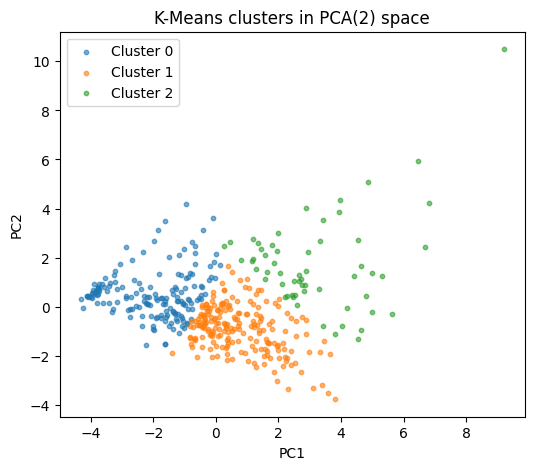

In [24]:
# Plot clusters in PCA space
plt.figure(figsize=(6,5))
for c in range(k):
    mask = labels_pca == c
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], s=10, alpha=0.6, label=f"Cluster {c}")
plt.title("K-Means clusters in PCA(2) space")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()


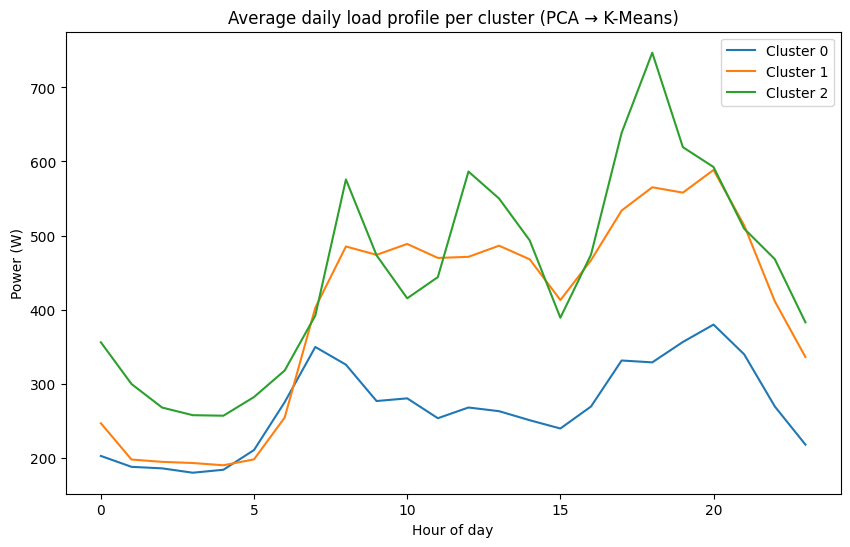

In [25]:
# Attach labels to original 24h profiles
profiles_pca = daily_profiles.copy()
profiles_pca["cluster_pca"] = labels_pca

# Average daily curve per cluster
cluster_means_pca = profiles_pca.groupby("cluster_pca").mean()

plt.figure(figsize=(10,6))
for c in cluster_means_pca.index:
    plt.plot(range(24),
             cluster_means_pca.loc[c],
             label=f"Cluster {c}")
plt.title("Average daily load profile per cluster (PCA → K-Means)")
plt.xlabel("Hour of day")
plt.ylabel("Power (W)")
plt.legend()
plt.show()


### Comparing K-Means with and without PCA

In [26]:
# KMeans on full 24D features
k = 3 
kmeans = KMeans(n_clusters=k, n_init=20, random_state=42)
labels_no_pca = kmeans.fit_predict(X_scaled)

sil_no_pca = silhouette_score(X_scaled, labels_no_pca)
print("Silhouette (no PCA):", sil_no_pca)


Silhouette (no PCA): 0.10121811133988447


In [27]:
# Reduce to 2 dimensions with PCA
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# KMeans on reduced PCA features
kmeans_pca = KMeans(n_clusters=k, n_init=20, random_state=42)
labels_pca = kmeans_pca.fit_predict(X_pca)

sil_pca = silhouette_score(X_pca, labels_pca)
print("Silhouette (with PCA):", sil_pca)


Silhouette (with PCA): 0.38340831262898434


In [28]:
print("=== Comparison ===")
print(f"K-Means (24D, no PCA): silhouette = {sil_no_pca:.3f}")
print(f"K-Means (2D, with PCA): silhouette = {sil_pca:.3f}")


=== Comparison ===
K-Means (24D, no PCA): silhouette = 0.101
K-Means (2D, with PCA): silhouette = 0.383
